In [2]:
import pandas as pd
import lightkurve as lk
import matplotlib.pyplot as plt
import numpy as np
from lightkurve import search_targetpixelfile
import __future__
import csv
import ast
from light_curve.binning import bin_and_aggregate


In [91]:
def generate_view(time,
                  values,
                  num_bins,
                  bin_width,
                  t_min,
                  t_max,
                  normalize=True):
  """Generates a view of a phase-folded and binned light curve.

  Args:
    time: 1D NumPy array of time values, sorted in ascending order.
    values: N-dimensional NumPy array with the same length as time.
    num_bins: The number of intervals to divide the time axis into.
    bin_width: The width of each bin on the time axis.
    t_min: The inclusive leftmost value to consider on the time axis.
    t_max: The exclusive rightmost value to consider on the time axis.
    normalize: Whether to center the median at 0 and minimum value at -1.

  Returns:
    NumPy array of length num_bins containing the aggregated values in uniformly
    spaced bins on the phase-folded time axis.
  """
  view, bin_counts = bin_and_aggregate(time, values, num_bins,
                                               bin_width, t_min, t_max)
  # Empty bins fall back to the global median.
  view = np.where(bin_counts > 0, view, np.median(values))

  if normalize:
    view -= np.median(view, axis=0)
    view /= np.abs(np.min(view, axis=0))

  return view


def global_view(time, values, period, num_bins=2001, bin_width_factor=1 / 2001):
  """Generates a 'global view' of a phase folded light curve.

  See Section 3.3 of Shallue & Vanderburg, 2018, The Astronomical Journal.
  http://iopscience.iop.org/article/10.3847/1538-3881/aa9e09/meta

  Args:
    time: 1D NumPy array of time values, sorted in ascending order.
    values: N-dimensional NumPy array with the same length as time.
    period: The period of the event (in days).
    num_bins: The number of intervals to divide the time axis into.
    bin_width_factor: Width of the bins, as a fraction of period.

  Returns:
    NumPy array of length num_bins containing the aggregated values in uniformly
    spaced bins on the phase-folded time axis.
  """
  return generate_view(
      time,
      values,
      num_bins=num_bins,
      bin_width=period * bin_width_factor,
      t_min=-period / 2,
      t_max=period / 2)


def local_view(time,
               values,
               period,
               duration,
               num_bins=201,
               bin_width_factor=0.16,
               num_durations=4):
  """Generates a 'local view' of a phase folded light curve.

  See Section 3.3 of Shallue & Vanderburg, 2018, The Astronomical Journal.
  http://iopscience.iop.org/article/10.3847/1538-3881/aa9e09/meta

  Args:
    time: 1D NumPy array of time values, sorted in ascending order.
    values: N-dimensional NumPy array with the same length as time.
    period: The period of the event (in days).
    duration: The duration of the event (in days).
    num_bins: The number of intervals to divide the time axis into.
    bin_width_factor: Width of the bins, as a fraction of duration.
    num_durations: The number of durations to consider on either side of 0 (the
      event is assumed to be centered at 0).

  Returns:
    NumPy array of length num_bins containing the aggregated values in uniformly
    spaced bins on the phase-folded time axis.
  """
  return generate_view(
      time,
      values,
      num_bins=num_bins,
      bin_width=duration * bin_width_factor,
      t_min=max(-period / 2, -duration * num_durations),
      t_max=min(period / 2, duration * num_durations))


In [3]:
def normalize_light_curve(light_curve):
    # Subtract the median to make median 0
    median_subtracted = light_curve - np.median(light_curve)
    
    # Scale so that the minimum value is -1
    scale_factor = np.abs(np.min(median_subtracted))
    normalized_light_curve = median_subtracted / scale_factor
    
    return normalized_light_curve


In [4]:
data=pd.read_csv('/Users/aridamansc/Desktop/exoplanet/kepler_TCE.csv')
data=data[data['av_training_set']!='UNK']
data

,loc_rowid,kepid,tce_plnt_num,tce_period,tce_period_err,tce_time0bk,tce_time0bk_err,tce_impact,tce_impact_err,tce_duration,...,tce_eqt_err,tce_insol,tce_insol_err,tce_steff,tce_steff_err,tce_slogg,tce_slogg_err,tce_sradius,tce_sradius_err,av_training_set
0,1,1162345,2,0.831850,6.693070e-05,132.227,0.035197,0.92600,1.471000,2.392,...,637.0,NaN,NaN,6510.0,207.0,4.07,0.26,1.728,0.791,AFP
3,4,1162345,3,0.831833,9.431020e-06,131.919,0.002209,0.09536,51.770000,2.181,...,637.0,NaN,NaN,6510.0,207.0,4.07,0.26,1.728,0.791,AFP
5,6,757450,1,8.884920,1.186150e-06,134.452,0.000101,0.05677,0.950200,2.078,...,27.6,NaN,NaN,5332.0,102.0,4.50,0.04,0.843,0.051,PC
6,7,892667,1,2.262110,2.726600e-05,132.171,0.006531,0.30000,10.610000,7.509,...,486.0,NaN,NaN,6609.0,236.0,4.11,0.28,1.654,0.811,NTP
7,8,892772,1,5.092600,3.144550e-05,133.451,0.004821,0.30000,16.090000,3.399,...,78.6,NaN,NaN,5037.0,197.0,4.55,0.12,0.751,0.127,AFP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20361,20362,11905761,2,3.580330,6.525820e-05,133.312,0.012868,0.08263,68.700000,13.260,...,406.0,NaN,NaN,6745.0,308.0,3.93,0.24,2.346,0.954,AFP
20363,20364,11908559,1,0.716006,1.242640e-05,132.019,0.002549,0.70000,0.626200,2.069,...,774.0,NaN,NaN,7224.0,309.0,3.89,0.24,2.508,1.039,AFP
20364,20365,11923562,2,0.739472,1.068170e-05,131.618,0.001399,0.28480,6.828000,2.146,...,997.0,NaN,NaN,7191.0,318.0,4.23,0.38,1.473,1.005,AFP
20365,20366,11923819,1,33.159500,9.532960e-07,159.812,0.000023,0.74720,0.019810,9.132,...,200.0,NaN,NaN,7968.0,323.0,3.95,0.23,2.390,0.854,AFP


In [5]:
data['av_training_set'] = data['av_training_set'].apply(lambda x: 1 if x == 'PC' else 0)


In [6]:
data = data[~data['kepid'].duplicated()] #removing duplicate kepids
data

,loc_rowid,kepid,tce_plnt_num,tce_period,tce_period_err,tce_time0bk,tce_time0bk_err,tce_impact,tce_impact_err,tce_duration,...,tce_eqt_err,tce_insol,tce_insol_err,tce_steff,tce_steff_err,tce_slogg,tce_slogg_err,tce_sradius,tce_sradius_err,av_training_set
0,1,1162345,2,0.83185,6.693070e-05,132.227,0.035197,0.92600,1.47100,2.392,...,637.0,NaN,NaN,6510.0,207.0,4.07,0.26,1.728,0.791,0
5,6,757450,1,8.88492,1.186150e-06,134.452,0.000101,0.05677,0.95020,2.078,...,27.6,NaN,NaN,5332.0,102.0,4.50,0.04,0.843,0.051,1
6,7,892667,1,2.26211,2.726600e-05,132.171,0.006531,0.30000,10.61000,7.509,...,486.0,NaN,NaN,6609.0,236.0,4.11,0.28,1.654,0.811,0
7,8,892772,1,5.09260,3.144550e-05,133.451,0.004821,0.30000,16.09000,3.399,...,78.6,NaN,NaN,5037.0,197.0,4.55,0.12,0.751,0.127,0
13,14,1026957,1,21.76130,1.002540e-05,144.779,0.000385,0.31800,1.36000,1.277,...,20.7,NaN,NaN,4859.0,105.0,4.61,0.06,0.723,0.053,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20350,20351,11766996,1,2.57015,3.561260e-05,132.004,0.008524,0.94720,0.03921,6.296,...,598.0,NaN,NaN,6982.0,233.0,4.19,0.35,1.582,0.984,0
20358,20359,11852982,1,13.81500,1.980510e-05,139.681,0.001159,0.92650,0.01786,2.526,...,18.2,NaN,NaN,3833.0,96.0,4.72,0.04,0.545,0.040,1
20359,20360,11853130,1,76.87940,4.380300e-05,146.882,0.000515,0.86230,0.02334,2.357,...,15.4,NaN,NaN,3587.0,62.0,4.89,0.08,0.380,0.060,1
20360,20361,11905761,1,3.58024,6.820920e-05,135.071,0.014266,0.09369,69.84000,11.990,...,406.0,NaN,NaN,6745.0,308.0,3.93,0.24,2.346,0.954,0


In [7]:
kepid,labels=[],[]
kepid=list(data['kepid'])
labels=list(data['av_training_set'])
for i in range(len(kepid)):
    kepid[i]=str('KIC '+str(kepid[i]))
kepid

['KIC 1162345',
 'KIC 757450',
 'KIC 892667',
 'KIC 892772',
 'KIC 1026957',
 'KIC 1160891',
 'KIC 1162150',
 'KIC 1161345',
 'KIC 1292087',
 'KIC 1573174',
 'KIC 1574792',
 'KIC 1575690',
 'KIC 1575873',
 'KIC 1865567',
 'KIC 2019227',
 'KIC 2019477',
 'KIC 2167600',
 'KIC 2306740',
 'KIC 2307199',
 'KIC 2439211',
 'KIC 2439243',
 'KIC 2554853',
 'KIC 2554867',
 'KIC 2578072',
 'KIC 2578077',
 'KIC 2693092',
 'KIC 2693097',
 'KIC 2714932',
 'KIC 2714947',
 'KIC 2714954',
 'KIC 2722074',
 'KIC 2854698',
 'KIC 2854914',
 'KIC 2987660',
 'KIC 2988145',
 'KIC 2992648',
 'KIC 2855603',
 'KIC 2856756',
 'KIC 2857323',
 'KIC 2857607',
 'KIC 2857722',
 'KIC 2860114',
 'KIC 2860594',
 'KIC 2860851',
 'KIC 2439798',
 'KIC 2969628',
 'KIC 2969638',
 'KIC 2970804',
 'KIC 2971415',
 'KIC 2693450',
 'KIC 2974858',
 'KIC 2975770',
 'KIC 2714955',
 'KIC 2985398',
 'KIC 2985587',
 'KIC 2985767',
 'KIC 2988768',
 'KIC 2989404',
 'KIC 1294670',
 'KIC 1576115',
 'KIC 1867630',
 'KIC 2167890',
 'KIC 23072

In [8]:
data2=pd.read_csv("final_exop_data.csv")
len(data)

9865

In [159]:
#GENERATING THE ENTIRE DATA WITH PREPROCESSING
csv_file = "final_exop_data.csv"

# Write data to the CSV file
with open(csv_file, mode='a', newline='') as file:
    writer = csv.writer(file)
    #writer.writerow(['kepid','raw_time','raw_flux','global_view','local_view'])
    for id in kepid:   # done from 9360 to 9820
        if id not in stored_ids:
            try:
                #search_result = lk.search_lightcurve("KIC 8462852", cadence='long')
                # Download all available Kepler light curves
                #lc_collection = search_result.download_all()
                pixelfile = search_targetpixelfile(id, quarter=16).download(quality_bitmask='hardest'); 
                lc = pixelfile.to_lightcurve(aperture_mask='all')#.remove_outliers();
                flattened_lc=lc.flatten(window_length=901)
                #lc = lc_collection.stitch().flatten(window_length=901).remove_outliers()
                # Create array of periods to search
                period = np.linspace(1, 20, 10000)
                # Create a BLSPeriodogram
                bls = flattened_lc.to_periodogram(method='bls', period=period, frequency_factor=500);
                planet_b_period = bls.period_at_max_power
                planet_b_t0 = bls.transit_time_at_max_power
                planet_b_dur = bls.duration_at_max_power
                folded_lc= flattened_lc.fold(period=planet_b_period, epoch_time=planet_b_t0)
                #binned_lc=folded_lc.bin(binsize=10) 
                global_vie=global_view(folded_lc['time'].value, folded_lc['flux'].value, period=planet_b_period.value, num_bins=2001, bin_width_factor=1 / 2001)
                local_vie=local_view(folded_lc['time'].value, folded_lc['flux'].value, period=planet_b_period.value,
                duration=planet_b_dur.value,
                num_bins=201,
                bin_width_factor=0.16,
                num_durations=4)
                #NORMALIZING THE VIEWS WITH MEDIAN 0 AND MIN VALUE OF -1
                norm_glo=normalize_light_curve(global_vie)
                norm_loc=normalize_light_curve(local_vie)
                writer.writerow([id,lc['time'].value,lc['flux'].value,norm_glo,norm_loc])
                print(id)
            except Exception as e:
                print(f"{id} had an error:", str(e))
                continue
        
        
    

KIC 1162345


KIC 757450
KIC 892667


KIC 892772


KIC 1026957


KIC 1160891
KIC 1162150


/Users/aridamansc/opt/anaconda3/lib/python3.9/site-packages/lightkurve/search.py:423: LightkurveWarning: Warning: 4 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


KIC 1161345
KIC 1292087
KIC 1573174
KIC 1574792


KIC 1575690


KIC 1575873


KIC 1865567


KIC 2019227
KIC 2019477


KIC 2167600


KIC 2306740
KIC 2307199
KIC 2439211


KIC 2439243


KIC 2554853
KIC 2554867


KIC 2578072


KIC 2578077


KIC 2693092
KIC 2693097


KIC 2714932
KIC 2714947


KIC 2714954
KIC 2722074


/Users/aridamansc/opt/anaconda3/lib/python3.9/site-packages/lightkurve/search.py:423: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


KIC 2854698
KIC 2854914


KIC 2987660


KIC 2988145
KIC 2992648


KIC 2855603


KIC 2856756


KIC 2857323


KIC 2857607
KIC 2857722


KIC 2860114
KIC 2860594


KIC 2860851


KIC 2439798


KIC 2969628
KIC 2969638


KIC 2970804


KIC 2971415


/Users/aridamansc/opt/anaconda3/lib/python3.9/site-packages/lightkurve/search.py:418: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


KIC 2693450
KIC 2974858 had an error: 'NoneType' object has no attribute 'to_lightcurve'
KIC 2975770


KIC 2714955
KIC 2985398


KIC 2985587
KIC 2985767


KIC 2988768


KIC 2989404


KIC 1294670


KIC 1576115


KIC 1867630


KIC 2167890


KIC 2307206
KIC 2307415
KIC 2440757 had an error: 'NoneType' object has no attribute 'to_lightcurve'


/Users/aridamansc/opt/anaconda3/lib/python3.9/site-packages/lightkurve/search.py:418: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


KIC 2441151


KIC 2441161
KIC 2556650


KIC 2578404


KIC 2578811


KIC 2578891
KIC 2693736


/Users/aridamansc/opt/anaconda3/lib/python3.9/site-packages/lightkurve/search.py:423: LightkurveWarning: Warning: 4 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


KIC 2694337
KIC 2715053
KIC 2715113
KIC 2715119


KIC 2715135


KIC 2830919


KIC 2831055


KIC 2854948


KIC 2854953
KIC 1295289


KIC 1295546


KIC 1296164
KIC 1576144


KIC 1869607
KIC 1870398


KIC 1870849
KIC 2021440


KIC 2168333


KIC 2307533


KIC 2308603


KIC 2441495


KIC 2441728


KIC 2557816


KIC 2578901


KIC 2695030
KIC 2695110


KIC 2696703
KIC 2715228


KIC 2715245
KIC 2831251


KIC 2832589


KIC 2832753
KIC 1429120


/Users/aridamansc/opt/anaconda3/lib/python3.9/site-packages/lightkurve/search.py:423: LightkurveWarning: Warning: 4 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


KIC 1871056


KIC 2141783


KIC 2282763


KIC 2308957


KIC 2309568


KIC 2309579
KIC 2442084


KIC 2442118


KIC 2442359


KIC 2558163


KIC 2558363


KIC 2558370


KIC 2579043


KIC 2579147
KIC 2696938
KIC 2707097 had an error: 'NoneType' object has no attribute 'to_lightcurve'


/Users/aridamansc/opt/anaconda3/lib/python3.9/site-packages/lightkurve/search.py:418: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


KIC 2715282
KIC 2715398


KIC 2715487


KIC 2833554


KIC 2859299


KIC 1429589


KIC 1429653
KIC 1576558


KIC 1577039


KIC 2141938


KIC 2142522


KIC 2283124


KIC 2283362


KIC 2309585


KIC 2309587
KIC 2309719
KIC 2442448


KIC 2443393


KIC 2558488


KIC 2568971


KIC 2579814
KIC 2580872


/Users/aridamansc/opt/anaconda3/lib/python3.9/site-packages/lightkurve/search.py:423: LightkurveWarning: Warning: 4 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


KIC 2707479
KIC 2707916


KIC 2715695


KIC 2716801


KIC 2835657


KIC 2837111


KIC 2860656
KIC 2860793


KIC 1430207


KIC 1430590


KIC 1872821


KIC 1872948


KIC 2157489


KIC 2297728


KIC 2309910
KIC 2310284


/Users/aridamansc/opt/anaconda3/lib/python3.9/site-packages/lightkurve/search.py:423: LightkurveWarning: Warning: 4 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


KIC 2444412
KIC 2445129


/Users/aridamansc/opt/anaconda3/lib/python3.9/site-packages/lightkurve/search.py:418: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


KIC 2569488
KIC 2569494 had an error: 'NoneType' object has no attribute 'to_lightcurve'


KIC 2569516


KIC 2581191
KIC 2707985


KIC 2708172


KIC 2716853


KIC 2717158
KIC 2846358


KIC 2849140
KIC 2860866


KIC 2860930


KIC 1430741


KIC 1431122
KIC 1717528
KIC 1717722


KIC 1718189


KIC 1873513
KIC 2158190


KIC 2158208
KIC 2297739


KIC 2297793
KIC 2422539


KIC 2436378


KIC 2445134
KIC 2445154
KIC 2570281


KIC 2570432


KIC 2570505
KIC 2581316
KIC 2708176 had an error: 'NoneType' object has no attribute 'to_lightcurve'


/Users/aridamansc/opt/anaconda3/lib/python3.9/site-packages/lightkurve/search.py:418: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


KIC 2708203
KIC 2708221


KIC 2708270


KIC 2717483


KIC 2849805


KIC 2969991
KIC 1431794
KIC 1718290


KIC 1995519


KIC 1995732
KIC 1996180


KIC 2159700
KIC 2159852
KIC 2437060 had an error: 'NoneType' object has no attribute 'to_lightcurve'


/Users/aridamansc/opt/anaconda3/lib/python3.9/site-packages/lightkurve/search.py:418: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


KIC 2437112
KIC 2445975
KIC 2570767


KIC 2570773


KIC 2581457
KIC 2581554
KIC 2708278
KIC 2708286


KIC 2708343


KIC 2718630
KIC 2718778
KIC 2851100
KIC 2852528


KIC 2852560
KIC 2970836


KIC 1432214
KIC 1432789


KIC 1718594
KIC 1996679
KIC 2161536
KIC 2161623 had an error: 'NoneType' object has no attribute 'to_lightcurve'


/Users/aridamansc/opt/anaconda3/lib/python3.9/site-packages/lightkurve/search.py:418: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
/Users/aridamansc/opt/anaconda3/lib/python3.9/site-packages/lightkurve/search.py:418: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


KIC 2300603
KIC 2437149 had an error: 'NoneType' object has no attribute 'to_lightcurve'


KIC 2446113
KIC 2446623


KIC 2571075
KIC 2571238


KIC 2571417


KIC 2581674
KIC 2708420


KIC 2708445


KIC 2718944


KIC 2719125


KIC 2852810
KIC 2973386


KIC 2973509


KIC 2973800


KIC 1433399
KIC 1718958
KIC 1719308
KIC 1720673


KIC 1996773


KIC 2010191


KIC 2010414
KIC 2302548
KIC 2437488


KIC 2437505


KIC 2447832
KIC 2583153


KIC 2708885


KIC 2710327


/Users/aridamansc/opt/anaconda3/lib/python3.9/site-packages/lightkurve/search.py:418: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


KIC 2710406
KIC 2719436 had an error: 'NoneType' object has no attribute 'to_lightcurve'
KIC 2719873
KIC 2852941
KIC 2853029


KIC 2853093


KIC 2853280
KIC 2976017
KIC 1433899
KIC 1433962


KIC 1721157
KIC 1721361


/Users/aridamansc/opt/anaconda3/lib/python3.9/site-packages/lightkurve/search.py:423: LightkurveWarning: Warning: 4 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


KIC 2162635
KIC 2162904 had an error: 'NoneType' object has no attribute 'to_lightcurve'


/Users/aridamansc/opt/anaconda3/lib/python3.9/site-packages/lightkurve/search.py:418: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


KIC 2303304
KIC 2303365


/Users/aridamansc/opt/anaconda3/lib/python3.9/site-packages/lightkurve/search.py:418: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


KIC 2303903
KIC 2437783 had an error: 'NoneType' object has no attribute 'to_lightcurve'
KIC 2448307 had an error: 'NoneType' object has no attribute 'to_lightcurve'


KIC 2449053
KIC 2449074


KIC 2571868
KIC 2572029
KIC 2573056


KIC 2710623


KIC 2719928


KIC 2985054


KIC 2985396


KIC 1433980


KIC 1434660


KIC 1724222


KIC 1724513
KIC 1724719


KIC 2011424


KIC 2012722


KIC 2163326
KIC 2164169
KIC 2304168


KIC 2304235
KIC 2437804


/Users/aridamansc/opt/anaconda3/lib/python3.9/site-packages/lightkurve/search.py:423: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


KIC 2438062


KIC 2449090
KIC 2449101


KIC 2574201


/Users/aridamansc/opt/anaconda3/lib/python3.9/site-packages/lightkurve/search.py:418: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


KIC 2574338
KIC 2574543 had an error: 'NoneType' object has no attribute 'to_lightcurve'


KIC 2583777
KIC 2584163
KIC 2711123


KIC 2711597


KIC 2720514
KIC 2720582
KIC 2853320
KIC 2986833


KIC 2987027


KIC 2987433
KIC 1434800


KIC 1724961


KIC 2013883


KIC 2014991


KIC 2015013


KIC 2164884


KIC 2165002
KIC 2304320
KIC 2438070
KIC 2438249


KIC 2438264


KIC 2449431
KIC 2450944


KIC 2584879


KIC 2584908
KIC 2585092


KIC 2711606


KIC 2720594


KIC 2853446


KIC 2853780
KIC 2853828


KIC 2989706


KIC 2990873
KIC 1571511


KIC 1571717


/Users/aridamansc/opt/anaconda3/lib/python3.9/site-packages/lightkurve/search.py:418: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


KIC 1725016
KIC 1725193 had an error: 'NoneType' object has no attribute 'to_lightcurve'
KIC 1849235
KIC 2016979


KIC 2018685


KIC 2165352


KIC 2166200


KIC 2166206


KIC 2305255
KIC 2305311
KIC 2305543 had an error: 'NoneType' object has no attribute 'to_lightcurve'
KIC 2438490 had an error: 'NoneType' object has no attribute 'to_lightcurve'


/Users/aridamansc/opt/anaconda3/lib/python3.9/site-packages/lightkurve/search.py:418: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
/Users/aridamansc/opt/anaconda3/lib/python3.9/site-packages/lightkurve/search.py:423: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


KIC 2438502


KIC 2452289


KIC 2452440


KIC 2575964


KIC 2576107
KIC 2576197


/Users/aridamansc/opt/anaconda3/lib/python3.9/site-packages/lightkurve/search.py:423: LightkurveWarning: Warning: 4 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


KIC 2692377


KIC 2713049


KIC 2714707


KIC 2720828


KIC 2721030


KIC 2853889


/Users/aridamansc/opt/anaconda3/lib/python3.9/site-packages/lightkurve/search.py:418: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


KIC 2854181
KIC 1572948 had an error: 'NoneType' object has no attribute 'to_lightcurve'
KIC 1849702


KIC 1865042
KIC 2019076


KIC 2166218
KIC 2305866


/Users/aridamansc/opt/anaconda3/lib/python3.9/site-packages/lightkurve/search.py:423: LightkurveWarning: Warning: 4 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


KIC 2438513


KIC 2438517


KIC 2452450


KIC 2452920
KIC 2576224
KIC 2576692


KIC 2577952
KIC 2714807
KIC 2714887


KIC 3351945


KIC 3352122
KIC 3440840


KIC 3440978


KIC 3441159


KIC 3449540


KIC 3450040


KIC 3453026


KIC 3534118
KIC 3534192
KIC 3547014


KIC 3547091
KIC 3560301


KIC 3644071


KIC 3644116


KIC 3660006


KIC 3660392


KIC 3748250
KIC 3764714


KIC 3764879


KIC 3765054


KIC 3103227
KIC 3103473


/Users/aridamansc/opt/anaconda3/lib/python3.9/site-packages/lightkurve/search.py:423: LightkurveWarning: Warning: 4 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


KIC 3109550
KIC 3128325


KIC 3128552
KIC 3230578


KIC 3240556
KIC 3323168
KIC 3323289
KIC 3340312


KIC 3340313


KIC 3340360


/Users/aridamansc/opt/anaconda3/lib/python3.9/site-packages/lightkurve/search.py:418: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


KIC 3353050
KIC 3353454 had an error: 'NoneType' object has no attribute 'to_lightcurve'
KIC 3354846


KIC 3453214
KIC 3453272
KIC 3539231
KIC 3539521


KIC 3547178
KIC 3560660


KIC 3560871


KIC 3644128
KIC 3644505
KIC 3644523
KIC 3660924
KIC 3749134
KIC 3749365


KIC 2993589
KIC 3109924
KIC 3109930
KIC 3109937


KIC 3110937


KIC 3128793
KIC 3230753
KIC 3230787
KIC 3230805


KIC 3240706


KIC 3324644
KIC 3341760
KIC 3354855
KIC 3355104
KIC 3441340


KIC 3441784


KIC 3453494
KIC 3539869
KIC 3547187
KIC 3547315


KIC 3561464
KIC 3561656


/Users/aridamansc/opt/anaconda3/lib/python3.9/site-packages/lightkurve/search.py:423: LightkurveWarning: Warning: 4 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


KIC 3644542


KIC 3644602
KIC 3661361
KIC 3749389


KIC 3749833


KIC 2994888


KIC 2995392
KIC 2995823
KIC 3112129
KIC 3113266
KIC 3130300
KIC 3130548
KIC 3231120


KIC 3231137


KIC 3241199


KIC 3241248


KIC 3324986


KIC 3326377
KIC 3326428
KIC 3341934
KIC 3356799
KIC 3454720


KIC 3454731
KIC 3541800


KIC 3541946


KIC 3547523
KIC 3547760
KIC 3561700 had an error: 'NoneType' object has no attribute 'to_lightcurve'


/Users/aridamansc/opt/anaconda3/lib/python3.9/site-packages/lightkurve/search.py:418: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


KIC 3644653


KIC 3645438
KIC 3661886
KIC 3662635
KIC 3749978


KIC 2996015
KIC 3114167
KIC 3114661
KIC 3114667


KIC 3114811


KIC 3216518
KIC 3216838


/Users/aridamansc/opt/anaconda3/lib/python3.9/site-packages/lightkurve/search.py:423: LightkurveWarning: Warning: 4 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


KIC 3231341


KIC 3241344


KIC 3241557
KIC 3327992
KIC 3342592


KIC 3342628


KIC 3425758
KIC 3442006


/Users/aridamansc/opt/anaconda3/lib/python3.9/site-packages/lightkurve/search.py:423: LightkurveWarning: Warning: 4 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


KIC 3548044


KIC 3548369


KIC 3629100


KIC 3629330
KIC 3645863


/Users/aridamansc/opt/anaconda3/lib/python3.9/site-packages/lightkurve/search.py:423: LightkurveWarning: Warning: 4 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


KIC 3662838


KIC 3663141
KIC 3752110


KIC 3756264


KIC 2997178


KIC 2997455
KIC 2997459
KIC 3115272


KIC 3115435


KIC 3115728


KIC 3217264
KIC 3231406


KIC 3241604


KIC 3241619


KIC 3241662


KIC 3241685


KIC 3327993


KIC 3328026


KIC 3328027
KIC 3342794
KIC 3342952


KIC 3342970


KIC 3425851
KIC 3426367


KIC 3427727


KIC 3442054
KIC 3442055
KIC 3442058


KIC 3455863
KIC 3542167
KIC 3542222
KIC 3542345
KIC 3629430


KIC 3629473
KIC 3646449
KIC 3663173


KIC 3663904


KIC 3757407
KIC 2998124
KIC 3115833


KIC 3217554
KIC 3231410


KIC 3244792


KIC 3328052


KIC 3328080
KIC 3329204


KIC 3343281


KIC 3427776
KIC 3456198


KIC 3542574
KIC 3548639


KIC 3548900
KIC 3629474


KIC 3629967
KIC 3632089
KIC 3648437


KIC 3649426
KIC 3650040


KIC 3728432


KIC 3728701
KIC 3730335


KIC 3757588
KIC 2998561


KIC 3001885
KIC 3116412


KIC 3117510


KIC 3218688
KIC 3218908


KIC 3232859
KIC 3233043


KIC 3245420


KIC 3329643


KIC 3329839


KIC 3330684
KIC 3330688
KIC 3344419


KIC 3344427
KIC 3345675


KIC 3428013
KIC 3428468
KIC 3443127


KIC 3443582


KIC 3443790


KIC 3456945
KIC 3542588


KIC 3543070


KIC 3550372
KIC 3550434


/Users/aridamansc/opt/anaconda3/lib/python3.9/site-packages/lightkurve/search.py:423: LightkurveWarning: Warning: 4 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


KIC 3632418


KIC 3633889


KIC 3650111


KIC 3730390
KIC 3732035


KIC 3757590
KIC 3757778
KIC 3002478


KIC 3003991
KIC 3117511


KIC 3117514


KIC 3118797


KIC 3219037
KIC 3233302
KIC 3234598
KIC 3245969
KIC 3246083
KIC 3246782


KIC 3335813


KIC 3336283


KIC 3346027
KIC 3346154


KIC 3429637
KIC 3429973
KIC 3444098 had an error: 'NoneType' object has no attribute 'to_lightcurve'


/Users/aridamansc/opt/anaconda3/lib/python3.9/site-packages/lightkurve/search.py:418: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


KIC 3444588
KIC 3444699


KIC 3457172
KIC 3457192


KIC 3543270


KIC 3553413
KIC 3553900


KIC 3554031
KIC 3634051


KIC 3654095


KIC 3654515


KIC 3732821


KIC 3732894


KIC 3733346


KIC 3733628


KIC 3758403


KIC 3003992
KIC 3097346


KIC 3097352
KIC 3119256


/Users/aridamansc/opt/anaconda3/lib/python3.9/site-packages/lightkurve/search.py:423: LightkurveWarning: Warning: 4 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


KIC 3219256
KIC 3219643
KIC 3234843


KIC 3236705
KIC 3246890


KIC 3336476
KIC 3346195


KIC 3431662


KIC 3433668


KIC 3437557
KIC 3445068
KIC 3445443
KIC 3445812


/Users/aridamansc/opt/anaconda3/lib/python3.9/site-packages/lightkurve/search.py:423: LightkurveWarning: Warning: 4 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


KIC 3458028


/Users/aridamansc/opt/anaconda3/lib/python3.9/site-packages/lightkurve/search.py:423: LightkurveWarning: Warning: 4 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


KIC 3544595
KIC 3544640
KIC 3554600


KIC 3555191


KIC 3634384
KIC 3635233
KIC 3654719
KIC 3654950


KIC 3655115


KIC 3734418
KIC 3758443
KIC 3758499
KIC 3759974


KIC 3097912


KIC 3097926


KIC 3119307


KIC 3119604


KIC 3219995


KIC 3238059


KIC 3238073


KIC 3238245
KIC 3246984


KIC 3336765
KIC 3336845


KIC 3336937
KIC 3347258


KIC 3347337
KIC 3437739


KIC 3437776
KIC 3446451
KIC 3446471


KIC 3458919
KIC 3458990


KIC 3459199
KIC 3544678
KIC 3544689


KIC 3544694


KIC 3556220


KIC 3640832


KIC 3655326


KIC 3655332


KIC 3734868


KIC 3735629


KIC 3735634


KIC 3742855


KIC 3760002


KIC 3098015


KIC 3120057


KIC 3222183


KIC 3238686
KIC 3239171
KIC 3247039


KIC 3337002
KIC 3337061


KIC 3337351
KIC 3347485


KIC 3437940
KIC 3446746


KIC 3446837


KIC 3459261


KIC 3526331


KIC 3529147
KIC 3544878
KIC 3544900


KIC 3545038
KIC 3557043
KIC 3557273


/Users/aridamansc/opt/anaconda3/lib/python3.9/site-packages/lightkurve/search.py:423: LightkurveWarning: Warning: 4 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


KIC 3640905
KIC 3641023


KIC 3655513
KIC 3744309
KIC 3761175


KIC 3761319
KIC 3761641


KIC 3098194


KIC 3120276


KIC 3120308


/Users/aridamansc/opt/anaconda3/lib/python3.9/site-packages/lightkurve/search.py:418: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


KIC 3120355
KIC 3222680 had an error: 'NoneType' object has no attribute 'to_lightcurve'
KIC 3223460
KIC 3228740


KIC 3228804


KIC 3239636


KIC 3239671
KIC 3239926


/Users/aridamansc/opt/anaconda3/lib/python3.9/site-packages/lightkurve/search.py:423: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


KIC 3247268


KIC 3247294
KIC 3247306


KIC 3347643


KIC 3438507
KIC 3438975


KIC 3438976


KIC 3439031


KIC 3447701


KIC 3529242


KIC 3529290


KIC 3545135


KIC 3557526
KIC 3557560
KIC 3656121
KIC 3656648
KIC 3745559


KIC 3745690
KIC 3762468


KIC 3098197


KIC 3120397


KIC 3120431
KIC 3120889


KIC 3228824
KIC 3228825
KIC 3228918


/Users/aridamansc/opt/anaconda3/lib/python3.9/site-packages/lightkurve/search.py:423: LightkurveWarning: Warning: 4 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


KIC 3239945


KIC 3240049
KIC 3247396
KIC 3247404


KIC 3337425


KIC 3337432
KIC 3337438
KIC 3337548


/Users/aridamansc/opt/anaconda3/lib/python3.9/site-packages/lightkurve/search.py:418: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


KIC 3348082
KIC 3439096 had an error: 'NoneType' object has no attribute 'to_lightcurve'
KIC 3439374


/Users/aridamansc/opt/anaconda3/lib/python3.9/site-packages/lightkurve/search.py:423: LightkurveWarning: Warning: 4 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


KIC 3447722


KIC 3448130


KIC 3530245
KIC 3530668


KIC 3545457
KIC 3545478
KIC 3558803 had an error: 'NoneType' object has no attribute 'to_lightcurve'


/Users/aridamansc/opt/anaconda3/lib/python3.9/site-packages/lightkurve/search.py:418: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


KIC 3558849


KIC 3641726
KIC 3642289


KIC 3656913
KIC 3746248


KIC 3762553


KIC 3762741


KIC 3763579


KIC 3098810


KIC 3098843
KIC 3120904
KIC 3121340
KIC 3228945
KIC 3228959
KIC 3228986
KIC 3240158
KIC 3240159


KIC 3247503
KIC 3247616
KIC 3338608


KIC 3338660
KIC 3348090
KIC 3348093
KIC 3348216
KIC 3348285


KIC 3348288
KIC 3440074


KIC 3440118


KIC 3448230
KIC 3448299


KIC 3448323


KIC 3448456


KIC 3531558


KIC 3532510


KIC 3532982
KIC 3545840
KIC 3546060


KIC 3546419
KIC 3558981
KIC 3559860
KIC 3642324
KIC 3642335
KIC 3657176
KIC 3657547
KIC 3657758
KIC 3747262


KIC 3747641


KIC 3101923


KIC 3102000


KIC 3122188
KIC 3122872


KIC 3228988
KIC 3229028
KIC 3229150


KIC 3240231
KIC 3240406
KIC 3248019
KIC 3338674


/Users/aridamansc/opt/anaconda3/lib/python3.9/site-packages/lightkurve/search.py:423: LightkurveWarning: Warning: 4 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


KIC 3338885


KIC 3348533


KIC 3440230


KIC 3448777


KIC 3532985
KIC 3533469
KIC 3546765


KIC 3559933


KIC 3559935
KIC 3642713


KIC 3642741
KIC 3659012
KIC 3747817


KIC 3764411
KIC 3102024


/Users/aridamansc/opt/anaconda3/lib/python3.9/site-packages/lightkurve/search.py:423: LightkurveWarning: Warning: 4 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


KIC 3102384


KIC 3103212


KIC 3122913


KIC 3122985
KIC 3124598
KIC 3230206


KIC 3230227
KIC 3240411
KIC 3248033


KIC 3248501


KIC 3339823
KIC 3340165
KIC 3351888
KIC 4664743


KIC 4664847


KIC 4679687


KIC 4679769


KIC 4740125
KIC 4740676
KIC 4740688
KIC 4758350


/Users/aridamansc/opt/anaconda3/lib/python3.9/site-packages/lightkurve/search.py:423: LightkurveWarning: Warning: 4 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


KIC 4758368


KIC 4773851


KIC 4774194


KIC 4840327
KIC 4840401


KIC 4840513
KIC 4850809
KIC 4850961
KIC 4850965
KIC 4861791


/Users/aridamansc/opt/anaconda3/lib/python3.9/site-packages/lightkurve/search.py:423: LightkurveWarning: Warning: 4 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


KIC 4862625
KIC 4918309
KIC 4919550
KIC 4935594


KIC 4935813
KIC 4458109


KIC 4458172


KIC 4476011


KIC 4488796


KIC 4556345


KIC 4556468
KIC 4557777


KIC 4579651


KIC 4647715
KIC 4647763
KIC 4665571
KIC 4665989


KIC 4665991


KIC 4679988


KIC 4741126


KIC 4742414
KIC 4742436
KIC 4760478


KIC 4760746


KIC 4760946
KIC 4774208


KIC 4840675
KIC 4851145
KIC 4851168
KIC 4851173


KIC 4851182


KIC 4919814


KIC 4919818


KIC 4384398
KIC 4384652
KIC 4458346
KIC 4476123


KIC 4476186
KIC 4488840
KIC 4562317


KIC 4562615
KIC 4584865
KIC 4649173


KIC 4666008
KIC 4667989
KIC 4680002


KIC 4742461
KIC 4743125


KIC 4743188
KIC 4761060


KIC 4774321


KIC 4813563
KIC 4813750


KIC 4841314


KIC 4841374
KIC 4842166


KIC 4851195


KIC 4862730
KIC 4920125
KIC 4384675


KIC 4384793
KIC 4458918


KIC 4458984
KIC 4459068


KIC 4476392
KIC 4477104
KIC 4540632
KIC 4563268


KIC 4565985
KIC 4586482


KIC 4587135
KIC 4649238
KIC 4668393


KIC 4680543


KIC 4680597


KIC 4743189


KIC 4761269


KIC 4814502
KIC 4815520
KIC 4815612 had an error: 'NoneType' object has no attribute 'to_lightcurve'


/Users/aridamansc/opt/anaconda3/lib/python3.9/site-packages/lightkurve/search.py:418: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


KIC 4842623


KIC 4851239
KIC 4851283 had an error: list index out of range
KIC 4862924


KIC 4862968
KIC 4927192
KIC 4385148 had an error: list index out of range


KIC 4386047
KIC 4459285 had an error: list index out of range


KIC 4459924


KIC 4477747
KIC 4477871
KIC 4544571


KIC 4566740


KIC 4566848


KIC 4587448
KIC 4587528


KIC 4649305
KIC 4669058


KIC 4669402


KIC 4680745
KIC 4680772


KIC 4743508
KIC 4743513


KIC 4763381
KIC 4819950
KIC 4820550
KIC 4843037
KIC 4843592
KIC 4851338


KIC 4851356
KIC 4851457


KIC 4863077
KIC 4863260
KIC 4927315


KIC 4927495


KIC 4386059


KIC 4386091


KIC 4386121


KIC 4459939


KIC 4464287


KIC 4478168
KIC 4479633
KIC 4544572


KIC 4567400


KIC 4567531
KIC 4568117


KIC 4588115
KIC 4649440
KIC 4670217
KIC 4670267


/Users/aridamansc/opt/anaconda3/lib/python3.9/site-packages/lightkurve/search.py:423: LightkurveWarning: Warning: 4 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


KIC 4725681


KIC 4749989
KIC 4750341
KIC 4764523


KIC 4824268
KIC 4825872
KIC 4844004
KIC 4844367


KIC 4851464


KIC 4863614


KIC 4927734
KIC 4927985


KIC 4464394


KIC 4479949
KIC 4544620


KIC 4568298
KIC 4568729


KIC 4633434
KIC 4633454
KIC 4649462


KIC 4649476


KIC 4670388


KIC 4670846


KIC 4725882
KIC 4726268
KIC 4750669


KIC 4751083
KIC 4752451


KIC 4764774


KIC 4764969


KIC 4826031
KIC 4845555


/Users/aridamansc/opt/anaconda3/lib/python3.9/site-packages/lightkurve/search.py:423: LightkurveWarning: Warning: 4 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


KIC 4851530


KIC 4852297
KIC 4852455
KIC 4863836
KIC 4863956


KIC 4928119


KIC 4391348
KIC 4464689
KIC 4465188


KIC 4480676
KIC 4481426


KIC 4544623
KIC 4569590


/Users/aridamansc/opt/anaconda3/lib/python3.9/site-packages/lightkurve/search.py:423: LightkurveWarning: Warning: 4 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


KIC 4633570
KIC 4634135
KIC 4650327
KIC 4650674


KIC 4671225


KIC 4729553
KIC 4731303
KIC 4731916
KIC 4753561


KIC 4768668


KIC 4826110
KIC 4826439
KIC 4827662
KIC 4845590
KIC 4845862
KIC 4846150


/Users/aridamansc/opt/anaconda3/lib/python3.9/site-packages/lightkurve/search.py:423: LightkurveWarning: Warning: 4 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


KIC 4852528
KIC 4864734 had an error: 'NoneType' object has no attribute 'to_lightcurve'


/Users/aridamansc/opt/anaconda3/lib/python3.9/site-packages/lightkurve/search.py:418: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


KIC 4929092
KIC 4929299


KIC 4929615


KIC 4391466
KIC 4446044


KIC 4466180


KIC 4481700
KIC 4544628


KIC 4544670
KIC 4544684


/Users/aridamansc/opt/anaconda3/lib/python3.9/site-packages/lightkurve/search.py:423: LightkurveWarning: Warning: 4 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


KIC 4570555
KIC 4570931


KIC 4570949


KIC 4636464
KIC 4650686


KIC 4650733


KIC 4650995
KIC 4672045


KIC 4732015


KIC 4754310


KIC 4754831
KIC 4768756


KIC 4768846
KIC 4827723
KIC 4828341


KIC 4846856


KIC 4908774
KIC 4909697
KIC 4930578
KIC 4930913


KIC 4446135
KIC 4446299
KIC 4466356
KIC 4466677


KIC 4482231


KIC 4482348


KIC 4544757


KIC 4544907


KIC 4545187
KIC 4636565


/Users/aridamansc/opt/anaconda3/lib/python3.9/site-packages/lightkurve/search.py:423: LightkurveWarning: Warning: 4 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


KIC 4636578
KIC 4656049


KIC 4658336


KIC 4672512
KIC 4673628
KIC 4676964


KIC 4733003


KIC 4733318


KIC 4755450


KIC 4755510


KIC 4769007
KIC 4829935
KIC 4830605


KIC 4831251


KIC 4847371
KIC 4857058


KIC 4857213
KIC 4909707
KIC 4912650


KIC 4931073


KIC 4448848


KIC 4449034


KIC 4450028
KIC 4471379


KIC 4482641
KIC 4482738


KIC 4483138


KIC 4545570
KIC 4545926
KIC 4547321
KIC 4571004
KIC 4571536


KIC 4571780


KIC 4638237
KIC 4639291
KIC 4659255


KIC 4659405


KIC 4677282
KIC 4677446


KIC 4733344


KIC 4831616
KIC 4831728


KIC 4847411


KIC 4847534


KIC 4847691


KIC 4858525
KIC 4912991
KIC 4913000
KIC 4913852
KIC 4913858


/Users/aridamansc/opt/anaconda3/lib/python3.9/site-packages/lightkurve/search.py:423: LightkurveWarning: Warning: 4 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


KIC 4450844
KIC 4451755


KIC 4471747
KIC 4472465


KIC 4483235


KIC 4483262
KIC 4547480
KIC 4547603 had an error: Not recognized as a supported data product:
/Users/aridamansc/.lightkurve/cache/mastDownload/Kepler/kplr004547603_lc_Q011111111111111111/kplr004547603-2013098041711_lpd-targ.fits.gz
This file may be corrupt due to an interrupted download. Please remove it from your disk and try again.


/Users/aridamansc/opt/anaconda3/lib/python3.9/site-packages/lightkurve/search.py:418: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


KIC 4547830
KIC 4571844 had an error: 'NoneType' object has no attribute 'to_lightcurve'


KIC 4639868


KIC 4640914


KIC 4640983
KIC 4660027
KIC 4661634


KIC 4678171
KIC 4735826


KIC 4736208
KIC 4736561


KIC 4736562


KIC 4756040


KIC 4756171


KIC 4769799
KIC 4769824
KIC 4769931


/Users/aridamansc/opt/anaconda3/lib/python3.9/site-packages/lightkurve/search.py:423: LightkurveWarning: Warning: 4 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


KIC 4831769


KIC 4832175
KIC 4832197
KIC 4847782


KIC 4847832
KIC 4858610


/Users/aridamansc/opt/anaconda3/lib/python3.9/site-packages/lightkurve/search.py:418: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


KIC 4859557
KIC 4914399 had an error: 'NoneType' object has no attribute 'to_lightcurve'
KIC 4914423


KIC 4931864
KIC 4932348
KIC 4932417
KIC 4454752
KIC 4454934


KIC 4472818


KIC 4473083
KIC 4548011


KIC 4574310


KIC 4641419


KIC 4641555
KIC 4661660
KIC 4678873
KIC 4678875
KIC 4678919


KIC 4736569


KIC 4756243
KIC 4770174
KIC 4770365


KIC 4832225
KIC 4832837
KIC 4847843
KIC 4848115
KIC 4848216
KIC 4859559


KIC 4860444
KIC 4914566
KIC 4914709


/Users/aridamansc/opt/anaconda3/lib/python3.9/site-packages/lightkurve/search.py:423: LightkurveWarning: Warning: 4 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


KIC 4932442
KIC 4932657
KIC 4455231


KIC 4473226
KIC 4473450
KIC 4483781


KIC 4484128


KIC 4548098
KIC 4576280


KIC 4644604
KIC 4644922


/Users/aridamansc/opt/anaconda3/lib/python3.9/site-packages/lightkurve/search.py:423: LightkurveWarning: Warning: 4 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


KIC 4644952
KIC 4662336
KIC 4679242
KIC 4679314


KIC 4736644


KIC 4737720


KIC 4756725
KIC 4756776
KIC 4770617
KIC 4833050


/Users/aridamansc/opt/anaconda3/lib/python3.9/site-packages/lightkurve/search.py:423: LightkurveWarning: Warning: 4 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


KIC 4833421


KIC 4848321
KIC 4848423
KIC 4848424


KIC 4848532
KIC 4860678
KIC 4914737
KIC 4914771
KIC 4932689
KIC 4932691
KIC 4455763
KIC 4456107
KIC 4473613


KIC 4473933
KIC 4484251


KIC 4551328


KIC 4551663


KIC 4577324
KIC 4577969


KIC 4645174


KIC 4663185


KIC 4679369


KIC 4738155
KIC 4739229


KIC 4757437


KIC 4771707


KIC 4773155


KIC 4848695


KIC 4860932
KIC 4861527


KIC 4915638
KIC 4915765
KIC 4916845


KIC 4933476
KIC 4934893


KIC 4456622


KIC 4456940
KIC 4474407


KIC 4474462


KIC 4484271


/Users/aridamansc/opt/anaconda3/lib/python3.9/site-packages/lightkurve/search.py:418: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


KIC 4552395
KIC 4552514 had an error: 'NoneType' object has no attribute 'to_lightcurve'


KIC 4578644
KIC 4579313


KIC 4645823
KIC 4645833
KIC 4664046


KIC 4664466
KIC 4679528


/Users/aridamansc/opt/anaconda3/lib/python3.9/site-packages/lightkurve/search.py:418: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


KIC 4739565
KIC 4739791 had an error: 'NoneType' object has no attribute 'to_lightcurve'
KIC 4757997
KIC 4773392


KIC 4839411
KIC 4850046
KIC 4850661
KIC 4850677


KIC 4850763
KIC 4861736


KIC 4861784
KIC 4917014


KIC 4917596
KIC 4918303
KIC 4935172
KIC 4935198


KIC 4458082
KIC 4474484
KIC 4474637


KIC 4474645


KIC 4484312
KIC 4484336


KIC 4552729


KIC 4555642


KIC 4555954
KIC 4579321


KIC 4579598
KIC 4050017


KIC 4054968
KIC 4073730
KIC 4136253
KIC 4136285 had an error: 'NoneType' object has no attribute 'to_lightcurve'


/Users/aridamansc/opt/anaconda3/lib/python3.9/site-packages/lightkurve/search.py:418: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


KIC 4150539


KIC 4150611


KIC 4171302


KIC 4171441


KIC 4243984


KIC 4244642


KIC 4269337
KIC 4372282
KIC 4383955
KIC 3846515 had an error: 'NoneType' object has no attribute 'to_lightcurve'


/Users/aridamansc/opt/anaconda3/lib/python3.9/site-packages/lightkurve/search.py:418: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


KIC 3847138


KIC 3847563


KIC 3847660
KIC 3858804
KIC 3858824
KIC 3858851


KIC 3867256
KIC 3945791
KIC 3964109


KIC 3964128
KIC 3971315


KIC 4055092


KIC 4074294
KIC 4074388
KIC 4136314
KIC 4136396
KIC 4172013
KIC 4172746


KIC 4172805


KIC 4173026
KIC 4245701
KIC 4270253
KIC 4270565


KIC 4270799


KIC 4285087
KIC 4285107


KIC 4285359
KIC 4372410


KIC 3765771
KIC 3765917
KIC 3847678
KIC 3847708
KIC 3858879


KIC 3858884


KIC 3867593
KIC 3867615


KIC 3945802


KIC 3945818
KIC 3964318


KIC 3964545


KIC 3972123


KIC 3972391
KIC 4055304 had an error: Not recognized as a supported data product:
/Users/aridamansc/.lightkurve/cache/mastDownload/Kepler/kplr004055304_lc_Q011111111111111111/kplr004055304-2013098041711_lpd-targ.fits.gz
This file may be corrupt due to an interrupted download. Please remove it from your disk and try again.


KIC 4055765


KIC 4074736
KIC 4136466
KIC 4136749
KIC 4137903
KIC 4150624
KIC 4150701
KIC 4150703


KIC 4174472
KIC 4245861


KIC 4245933


KIC 4247092
KIC 4270987
KIC 4346178
KIC 4346875
KIC 4372765


KIC 4372768
KIC 3766353
KIC 3847907
KIC 3848275
KIC 3858917


KIC 3867794
KIC 3868284


KIC 3945892


KIC 3964562
KIC 3965201


KIC 3973504
KIC 3973549
KIC 4055774


KIC 4056616
KIC 4058169
KIC 4075015
KIC 4075064


KIC 4075067


KIC 4138008


KIC 4150804
KIC 4155328


KIC 4156254
KIC 4174754


KIC 4175105
KIC 4247791


KIC 4247807
KIC 4247811
KIC 4271063
KIC 4271474


KIC 4373195
KIC 4374339
KIC 4374610


KIC 3830820
KIC 3831053
KIC 3848665
KIC 3848919


KIC 3848948
KIC 3848966


KIC 3858919
KIC 3858926


KIC 3868420


KIC 3946023
KIC 3951334


KIC 3965242


KIC 3974401
KIC 3975085


KIC 4058206


KIC 4138848


KIC 4138951
KIC 4139254
KIC 4156309


/Users/aridamansc/opt/anaconda3/lib/python3.9/site-packages/lightkurve/search.py:423: LightkurveWarning: Warning: 4 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


KIC 4157325


KIC 4175630
KIC 4176455


/Users/aridamansc/opt/anaconda3/lib/python3.9/site-packages/lightkurve/search.py:423: LightkurveWarning: Warning: 4 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


KIC 4247991
KIC 4248120
KIC 4249611


/Users/aridamansc/opt/anaconda3/lib/python3.9/site-packages/lightkurve/search.py:423: LightkurveWarning: Warning: 4 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


KIC 4249725


KIC 4271930


KIC 4273425
KIC 4349442


/Users/aridamansc/opt/anaconda3/lib/python3.9/site-packages/lightkurve/search.py:423: LightkurveWarning: Warning: 4 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


KIC 4349452


KIC 4374812


KIC 3831523
KIC 3831746
KIC 3848972
KIC 3849014


KIC 3849155
KIC 3858949


KIC 3858988


KIC 3868442


KIC 3868759
KIC 3869014
KIC 3952431
KIC 3965879
KIC 4035640


KIC 4035667
KIC 4058881


KIC 4059007


KIC 4075172
KIC 4139351
KIC 4178173
KIC 4252226


KIC 4252322


KIC 4274480
KIC 4349612


KIC 4375101
KIC 3831911
KIC 3849187
KIC 3849354


/Users/aridamansc/opt/anaconda3/lib/python3.9/site-packages/lightkurve/search.py:423: LightkurveWarning: Warning: 4 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


KIC 3859079
KIC 3859151
KIC 3859363


KIC 3869322


KIC 3869326
KIC 3952651
KIC 3953106 had an error: 'NoneType' object has no attribute 'to_lightcurve'


/Users/aridamansc/opt/anaconda3/lib/python3.9/site-packages/lightkurve/search.py:418: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


KIC 3953173
KIC 3966262


KIC 3966273


KIC 4035675


KIC 4037428
KIC 4059887
KIC 4060229
KIC 4060976


KIC 4061149
KIC 4076098
KIC 4139673 had an error: 'NoneType' object has no attribute 'to_lightcurve'


/Users/aridamansc/opt/anaconda3/lib/python3.9/site-packages/lightkurve/search.py:418: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
/Users/aridamansc/opt/anaconda3/lib/python3.9/site-packages/lightkurve/search.py:423: LightkurveWarning: Warning: 3 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


KIC 4139816


KIC 4158822
KIC 4158876


KIC 4178376


KIC 4178389
KIC 4178606


KIC 4252716
KIC 4252757


KIC 4274548
KIC 4274730
KIC 4376629


KIC 4376644
KIC 4377638


/Users/aridamansc/opt/anaconda3/lib/python3.9/site-packages/lightkurve/search.py:423: LightkurveWarning: Warning: 4 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


KIC 3832474
KIC 3832716


KIC 3849415


KIC 3859628


KIC 3860441
KIC 3869794
KIC 3869825


KIC 3954136


KIC 3966491


KIC 4038095


KIC 4064365
KIC 4076976
KIC 4077006
KIC 4140813


/Users/aridamansc/opt/anaconda3/lib/python3.9/site-packages/lightkurve/search.py:423: LightkurveWarning: Warning: 4 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


KIC 4141376


/Users/aridamansc/opt/anaconda3/lib/python3.9/site-packages/lightkurve/search.py:418: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


KIC 4159347
KIC 4160006 had an error: 'NoneType' object has no attribute 'to_lightcurve'


KIC 4178654
KIC 4179599


KIC 4253413


KIC 4253860
KIC 4274748


KIC 4275117


KIC 4352168


KIC 4355012


KIC 4378863


KIC 4379599
KIC 3833007
KIC 3850331
KIC 3850551


KIC 3850810


KIC 3861139
KIC 3861414
KIC 3954227
KIC 3954798


KIC 3955026
KIC 3966801


KIC 3966912
KIC 4066066


KIC 4077032


KIC 4077252
KIC 4141464


KIC 4160676
KIC 4180099


KIC 4180199


KIC 4254466


KIC 4254741
KIC 4275186
KIC 4275191


KIC 4275328
KIC 4356621


KIC 4380558


KIC 3834322
KIC 3834360
KIC 3851130


KIC 3851134
KIC 3861595
KIC 3861611
KIC 3935914
KIC 3955817


KIC 3955867
KIC 3967085


KIC 3967219


KIC 3967268


KIC 4042026


KIC 4042088


KIC 4042590
KIC 4067110
KIC 4077275


KIC 4077526


KIC 4141670


KIC 4141760
KIC 4142768


KIC 4160683


KIC 4180280
KIC 4255422
KIC 4275721
KIC 4275739
KIC 4356766
KIC 4357960


KIC 4380834


KIC 4380951


: 

: 

In [132]:
#search_result = lk.search_lightcurve("KIC 8462852", cadence='long')
# Download all available Kepler light curves
#lc_collection = search_result.download_all()
pixelfile = search_targetpixelfile('KIC 8191672', quarter=16).download(quality_bitmask='hardest'); 
lc = pixelfile.to_lightcurve(aperture_mask='all').flatten(window_length=901)#.remove_outliers();
          
#lc = lc_collection.stitch().flatten(window_length=901).remove_outliers()
 # Create array of periods to search
period = np.linspace(1, 20, 10000)
# Create a BLSPeriodogram
bls = lc.to_periodogram(method='bls', period=period, frequency_factor=500);
planet_b_period = bls.period_at_max_power
planet_b_t0 = bls.transit_time_at_max_power
planet_b_dur = bls.duration_at_max_power
folded_lc= lc.fold(period=planet_b_period, epoch_time=planet_b_t0)
#binned_lc=folded_lc.bin(binsize=10) 
            

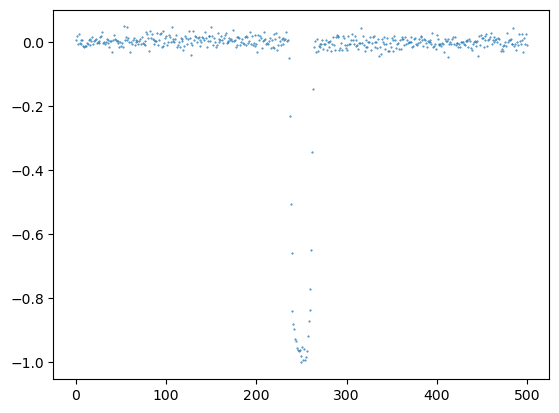

In [83]:
len(folded_lc['time'].value)
x=np.array([i for i in range(501)])
y=global_view(folded_lc['time'].value, folded_lc['flux'].value, period=planet_b_period.value, num_bins=501, bin_width_factor=1 / 501)
plt.scatter(x,y,s=0.2)

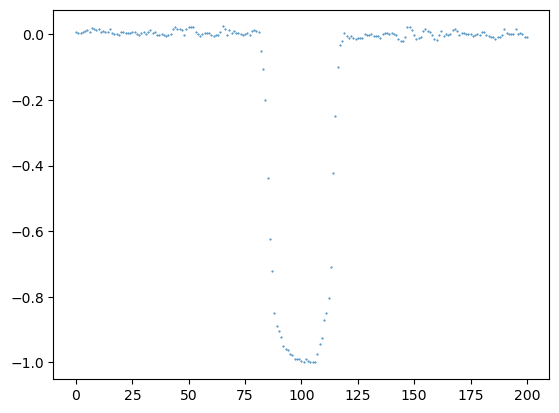

In [84]:
y2=local_view(folded_lc['time'].value, folded_lc['flux'].value, period=planet_b_period.value,
            duration=planet_b_dur.value,
            num_bins=201,
            bin_width_factor=0.16,
            num_durations=4)
x2=np.array([i for i in range(201)])
plt.scatter(x2,y2,s=0.2)

<Figure size 1000x600 with 0 Axes>

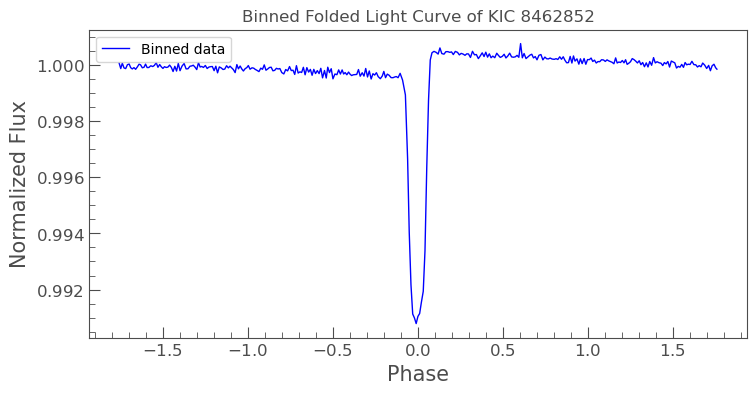

337

In [45]:
import matplotlib.pyplot as plt

# Plot the binned light curve
plt.figure(figsize=(10, 6))
binned_lc.plot(linewidth=1, label='Binned data', color='blue')
plt.title('Binned Folded Light Curve of KIC 8462852')
plt.xlabel('Phase')
plt.ylabel('Normalized Flux')
plt.legend()
plt.show()
len(binned_lc['flux'])


In [152]:
kepid.index('KIC 12554634')

9359

In [595]:
data2= data2.drop_duplicates()

len(data2)

8886

In [596]:
data2['labels']=None

In [597]:
for id in data2['kepid']:
    # Check if the 'id' exists in data['kepid']
    if id in data['kepid']:
        # Find the corresponding label in data and assign it to data2
        label = data[data['kepid'] == id]['labels'].values[0]
        data2.loc[data2['kepid'] == id, 'labels'] = label

In [598]:
data2['labels']

0       None
1       None
2       None
3       None
4       None
        ... 
8881    None
8882    None
8883    None
8884    None
8885    None
Name: labels, Length: 8886, dtype: object

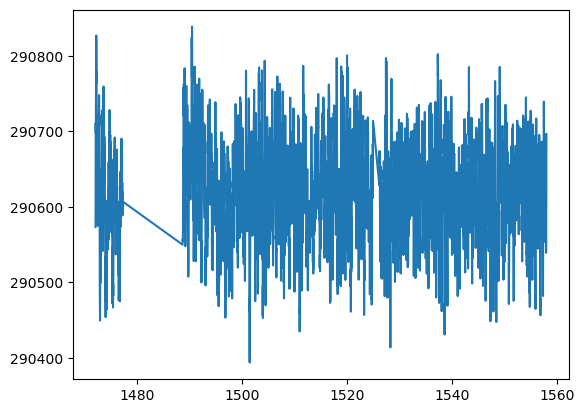

In [599]:
x=data2['flux'][0][1:-1].split(',')
# Convert the list of strings to a list of integers
x= [float(item) for item in x]
plt.plot(ast.literal_eval(data2['time'][0]),x)
plt.show()

In [600]:
x=data2['flux'][0][1:-1].split(',')
# Convert the list of strings to a list of integers
x= [float(item) for item in x]
x

[290573.1875,
 290615.40625,
 290711.09375,
 290697.0625,
 290749.46875,
 290780.5,
 290763.4375,
 290826.96875,
 290803.375,
 290771.09375,
 290747.5625,
 290729.78125,
 290671.1875,
 290630.65625,
 290669.4375,
 290611.84375,
 290644.21875,
 290722.84375,
 290649.59375,
 290674.1875,
 290627.40625,
 290574.8125,
 290674.125,
 290650.5,
 290705.6875,
 290686.65625,
 290649.0,
 290674.15625,
 290691.6875,
 290632.3125,
 290662.625,
 290685.03125,
 290708.8125,
 290748.125,
 290707.65625,
 290721.8125,
 290715.75,
 290626.65625,
 290645.875,
 290558.15625,
 290486.59375,
 290449.40625,
 290483.96875,
 290515.71875,
 290499.03125,
 290543.65625,
 290512.9375,
 290509.59375,
 290628.96875,
 290650.0625,
 290645.09375,
 290628.09375,
 290611.75,
 290625.59375,
 290618.9375,
 290613.90625,
 290595.09375,
 290657.90625,
 290687.8125,
 290727.90625,
 290678.90625,
 290653.53125,
 290645.5,
 290621.03125,
 290598.5,
 290541.40625,
 290591.5,
 290596.28125,
 290606.46875,
 290663.0625,
 290602.

In [601]:
ast.literal_eval(data2['time'][0])

[1472.1167966736903,
 1472.1372297143098,
 1472.1576625552843,
 1472.1780955964932,
 1472.1985285380433,
 1472.2189613799492,
 1472.2393944220894,
 1472.2598273645708,
 1472.2802602075244,
 1472.300693250596,
 1472.321126194125,
 1472.3415591380108,
 1472.3619920821293,
 1472.3824250265898,
 1472.4028580714075,
 1472.4232909164566,
 1472.4437238619648,
 1472.464156907714,
 1472.4845898538042,
 1472.5050227002503,
 1472.5254557469307,
 1472.545888694076,
 1472.5663216414468,
 1472.5867545891742,
 1472.6071875372436,
 1472.627620485553,
 1472.6480534342118,
 1472.6684863833361,
 1472.6889193325696,
 1472.709352282276,
 1472.729785132331,
 1472.750218182613,
 1472.7706511332508,
 1472.7910841842313,
 1472.8115170355668,
 1472.8319499871359,
 1472.8523830391641,
 1472.872815891431,
 1472.8932488440478,
 1472.913681896891,
 1472.9341147502055,
 1472.974980757761,
 1472.9954137118912,
 1473.015846666487,
 1473.036279621425,
 1473.0567125766029,
 1473.07714553213,
 1473.0975784879993,
 1473.1

In [602]:
data2.flux

0       [290573.1875, 290615.40625, 290711.09375, 2906...
1       [11482.1005859375, 11476.09765625, 11474.22949...
2       [76636.7421875, 76644.0390625, 76627.0859375, ...
3       [12183.046875, 12195.359375, 12198.2783203125,...
4       [119163.3046875, 119160.125, 119167.234375, 11...
                              ...                        
8881    [564531.3125, 564531.5, 564517.875, 564634.562...
8882    [8410.2421875, 8407.896484375, 8421.0, 8405.93...
8883    [54430.8984375, 54404.71484375, 54399.80859375...
8884    [46273.203125, 46290.1875, 46293.23828125, 463...
8885    [19512.216796875, 19538.76171875, 19522.939453...
Name: flux, Length: 8886, dtype: object

In [603]:
data2.reset_index()

,index,Unnamed: 0,kepid,time,flux,labels
0,0,0,KIC 1162345,"[1472.1167966736903, 1472.1372297143098, 1472....","[290573.1875, 290615.40625, 290711.09375, 2906...",None
1,1,1,KIC 757450,"[1472.11677061738, 1472.1372036586981, 1472.15...","[11482.1005859375, 11476.09765625, 11474.22949...",None
2,2,2,KIC 892667,"[1472.116773827649, 1472.137206869782, 1472.15...","[76636.7421875, 76644.0390625, 76627.0859375, ...",None
3,3,3,KIC 892772,"[1472.1167791773987, 1472.1372122192988, 1472....","[12183.046875, 12195.359375, 12198.2783203125,...",None
4,4,4,KIC 1026957,"[1472.1167874504536, 1472.1372204903746, 1472....","[119163.3046875, 119160.125, 119167.234375, 11...",None
...,...,...,...,...,...,...
8881,8881,8885,KIC 12833566,"[1472.1180650266251, 1472.1384982777527, 1472....","[564531.3125, 564531.5, 564517.875, 564634.562...",None
8882,8882,8886,KIC 12833701,"[1472.118060263172, 1472.138493511913, 1472.15...","[8410.2421875, 8407.896484375, 8421.0, 8405.93...",None
8883,8883,8887,KIC 12554212,"[1472.1179938854839, 1472.1384271403658, 1472....","[54430.8984375, 54404.71484375, 54399.80859375...",None
8884,8884,8888,KIC 12554510,"[1472.117998412934, 1472.1384316637705, 1472.1...","[46273.203125, 46290.1875, 46293.23828125, 463...",None


In [546]:
data

,loc_rowid,kepid,tce_plnt_num,tce_period,tce_period_err,tce_time0bk,tce_time0bk_err,tce_impact,tce_impact_err,tce_duration,...,tce_eqt_err,tce_insol,tce_insol_err,tce_steff,tce_steff_err,tce_slogg,tce_slogg_err,tce_sradius,tce_sradius_err,av_training_set
0,1,1162345,2,0.831850,6.693070e-05,132.227,0.035197,0.92600,1.471000,2.392,...,637.0,NaN,NaN,6510.0,207.0,4.07,0.26,1.728,0.791,AFP
3,4,1162345,3,0.831833,9.431020e-06,131.919,0.002209,0.09536,51.770000,2.181,...,637.0,NaN,NaN,6510.0,207.0,4.07,0.26,1.728,0.791,AFP
5,6,757450,1,8.884920,1.186150e-06,134.452,0.000101,0.05677,0.950200,2.078,...,27.6,NaN,NaN,5332.0,102.0,4.50,0.04,0.843,0.051,PC
6,7,892667,1,2.262110,2.726600e-05,132.171,0.006531,0.30000,10.610000,7.509,...,486.0,NaN,NaN,6609.0,236.0,4.11,0.28,1.654,0.811,NTP
7,8,892772,1,5.092600,3.144550e-05,133.451,0.004821,0.30000,16.090000,3.399,...,78.6,NaN,NaN,5037.0,197.0,4.55,0.12,0.751,0.127,AFP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20361,20362,11905761,2,3.580330,6.525820e-05,133.312,0.012868,0.08263,68.700000,13.260,...,406.0,NaN,NaN,6745.0,308.0,3.93,0.24,2.346,0.954,AFP
20363,20364,11908559,1,0.716006,1.242640e-05,132.019,0.002549,0.70000,0.626200,2.069,...,774.0,NaN,NaN,7224.0,309.0,3.89,0.24,2.508,1.039,AFP
20364,20365,11923562,2,0.739472,1.068170e-05,131.618,0.001399,0.28480,6.828000,2.146,...,997.0,NaN,NaN,7191.0,318.0,4.23,0.38,1.473,1.005,AFP
20365,20366,11923819,1,33.159500,9.532960e-07,159.812,0.000023,0.74720,0.019810,9.132,...,200.0,NaN,NaN,7968.0,323.0,3.95,0.23,2.390,0.854,AFP


In [606]:
for i in range(len(data2['kepid'])):
    kepid=int(list(data2['kepid'])[i][4:])
    label=data[data['kepid']==kepid]['av_training_set']
    label=list(label)[0]
    data2.loc[i,'labels']=label

In [607]:
data2

,Unnamed: 0,kepid,time,flux,labels
0,0,KIC 1162345,"[1472.1167966736903, 1472.1372297143098, 1472....","[290573.1875, 290615.40625, 290711.09375, 2906...",AFP
1,1,KIC 757450,"[1472.11677061738, 1472.1372036586981, 1472.15...","[11482.1005859375, 11476.09765625, 11474.22949...",PC
2,2,KIC 892667,"[1472.116773827649, 1472.137206869782, 1472.15...","[76636.7421875, 76644.0390625, 76627.0859375, ...",NTP
3,3,KIC 892772,"[1472.1167791773987, 1472.1372122192988, 1472....","[12183.046875, 12195.359375, 12198.2783203125,...",AFP
4,4,KIC 1026957,"[1472.1167874504536, 1472.1372204903746, 1472....","[119163.3046875, 119160.125, 119167.234375, 11...",AFP
...,...,...,...,...,...
8881,8885,KIC 12833566,"[1472.1180650266251, 1472.1384982777527, 1472....","[564531.3125, 564531.5, 564517.875, 564634.562...",NTP
8882,8886,KIC 12833701,"[1472.118060263172, 1472.138493511913, 1472.15...","[8410.2421875, 8407.896484375, 8421.0, 8405.93...",NTP
8883,8887,KIC 12554212,"[1472.1179938854839, 1472.1384271403658, 1472....","[54430.8984375, 54404.71484375, 54399.80859375...",PC
8884,8888,KIC 12554510,"[1472.117998412934, 1472.1384316637705, 1472.1...","[46273.203125, 46290.1875, 46293.23828125, 463...",AFP


In [608]:
data2

,Unnamed: 0,kepid,time,flux,labels
0,0,KIC 1162345,"[1472.1167966736903, 1472.1372297143098, 1472....","[290573.1875, 290615.40625, 290711.09375, 2906...",AFP
1,1,KIC 757450,"[1472.11677061738, 1472.1372036586981, 1472.15...","[11482.1005859375, 11476.09765625, 11474.22949...",PC
2,2,KIC 892667,"[1472.116773827649, 1472.137206869782, 1472.15...","[76636.7421875, 76644.0390625, 76627.0859375, ...",NTP
3,3,KIC 892772,"[1472.1167791773987, 1472.1372122192988, 1472....","[12183.046875, 12195.359375, 12198.2783203125,...",AFP
4,4,KIC 1026957,"[1472.1167874504536, 1472.1372204903746, 1472....","[119163.3046875, 119160.125, 119167.234375, 11...",AFP
...,...,...,...,...,...
8881,8885,KIC 12833566,"[1472.1180650266251, 1472.1384982777527, 1472....","[564531.3125, 564531.5, 564517.875, 564634.562...",NTP
8882,8886,KIC 12833701,"[1472.118060263172, 1472.138493511913, 1472.15...","[8410.2421875, 8407.896484375, 8421.0, 8405.93...",NTP
8883,8887,KIC 12554212,"[1472.1179938854839, 1472.1384271403658, 1472....","[54430.8984375, 54404.71484375, 54399.80859375...",PC
8884,8888,KIC 12554510,"[1472.117998412934, 1472.1384316637705, 1472.1...","[46273.203125, 46290.1875, 46293.23828125, 463...",AFP


In [609]:
data2.to_csv('final_exop_data.csv')

In [610]:
data2

,Unnamed: 0,kepid,time,flux,labels
0,0,KIC 1162345,"[1472.1167966736903, 1472.1372297143098, 1472....","[290573.1875, 290615.40625, 290711.09375, 2906...",AFP
1,1,KIC 757450,"[1472.11677061738, 1472.1372036586981, 1472.15...","[11482.1005859375, 11476.09765625, 11474.22949...",PC
2,2,KIC 892667,"[1472.116773827649, 1472.137206869782, 1472.15...","[76636.7421875, 76644.0390625, 76627.0859375, ...",NTP
3,3,KIC 892772,"[1472.1167791773987, 1472.1372122192988, 1472....","[12183.046875, 12195.359375, 12198.2783203125,...",AFP
4,4,KIC 1026957,"[1472.1167874504536, 1472.1372204903746, 1472....","[119163.3046875, 119160.125, 119167.234375, 11...",AFP
...,...,...,...,...,...
8881,8885,KIC 12833566,"[1472.1180650266251, 1472.1384982777527, 1472....","[564531.3125, 564531.5, 564517.875, 564634.562...",NTP
8882,8886,KIC 12833701,"[1472.118060263172, 1472.138493511913, 1472.15...","[8410.2421875, 8407.896484375, 8421.0, 8405.93...",NTP
8883,8887,KIC 12554212,"[1472.1179938854839, 1472.1384271403658, 1472....","[54430.8984375, 54404.71484375, 54399.80859375...",PC
8884,8888,KIC 12554510,"[1472.117998412934, 1472.1384316637705, 1472.1...","[46273.203125, 46290.1875, 46293.23828125, 463...",AFP


In [611]:
data2['labels'] = data2['labels'].replace({'PC': 1, 'AFP': 0, 'NTP': 0})

# Display the updated data2 DataFrame
print(data2)

      Unnamed: 0         kepid  \
0              0   KIC 1162345   
1              1    KIC 757450   
2              2    KIC 892667   
3              3    KIC 892772   
4              4   KIC 1026957   
...          ...           ...   
8881        8885  KIC 12833566   
8882        8886  KIC 12833701   
8883        8887  KIC 12554212   
8884        8888  KIC 12554510   
8885        8889  KIC 12834874   

                                                   time  \
0     [1472.1167966736903, 1472.1372297143098, 1472....   
1     [1472.11677061738, 1472.1372036586981, 1472.15...   
2     [1472.116773827649, 1472.137206869782, 1472.15...   
3     [1472.1167791773987, 1472.1372122192988, 1472....   
4     [1472.1167874504536, 1472.1372204903746, 1472....   
...                                                 ...   
8881  [1472.1180650266251, 1472.1384982777527, 1472....   
8882  [1472.118060263172, 1472.138493511913, 1472.15...   
8883  [1472.1179938854839, 1472.1384271403658, 1472....   
8

In [612]:
data2

,Unnamed: 0,kepid,time,flux,labels
0,0,KIC 1162345,"[1472.1167966736903, 1472.1372297143098, 1472....","[290573.1875, 290615.40625, 290711.09375, 2906...",0
1,1,KIC 757450,"[1472.11677061738, 1472.1372036586981, 1472.15...","[11482.1005859375, 11476.09765625, 11474.22949...",1
2,2,KIC 892667,"[1472.116773827649, 1472.137206869782, 1472.15...","[76636.7421875, 76644.0390625, 76627.0859375, ...",0
3,3,KIC 892772,"[1472.1167791773987, 1472.1372122192988, 1472....","[12183.046875, 12195.359375, 12198.2783203125,...",0
4,4,KIC 1026957,"[1472.1167874504536, 1472.1372204903746, 1472....","[119163.3046875, 119160.125, 119167.234375, 11...",0
...,...,...,...,...,...
8881,8885,KIC 12833566,"[1472.1180650266251, 1472.1384982777527, 1472....","[564531.3125, 564531.5, 564517.875, 564634.562...",0
8882,8886,KIC 12833701,"[1472.118060263172, 1472.138493511913, 1472.15...","[8410.2421875, 8407.896484375, 8421.0, 8405.93...",0
8883,8887,KIC 12554212,"[1472.1179938854839, 1472.1384271403658, 1472....","[54430.8984375, 54404.71484375, 54399.80859375...",1
8884,8888,KIC 12554510,"[1472.117998412934, 1472.1384316637705, 1472.1...","[46273.203125, 46290.1875, 46293.23828125, 463...",0


In [1]:
data2.to_csv('final_exop_data.csv')

NameError: name 'data2' is not defined